In [1]:
# Importing Python libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from sklearn.metrics import confusion_matrix

# is it using the GPU?
print(tf.test.gpu_device_name())

# Show current TensorFlow version
tf.__version__

/device:GPU:0


'2.10.1'

In [2]:
training_file = "../../data/train.p"
validation_file= "../../data/valid.p"
testing_file = "../../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [3]:
# Mapping ClassID to traffic sign names
signs = []
with open('../../data/signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

In [4]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

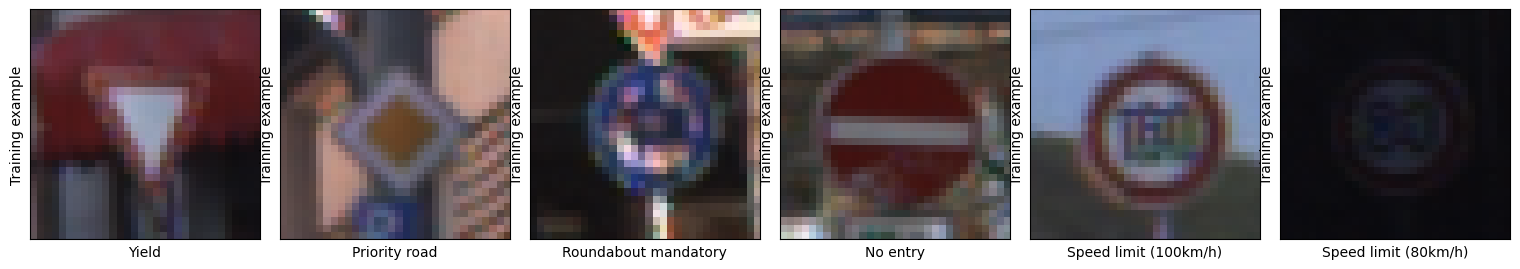

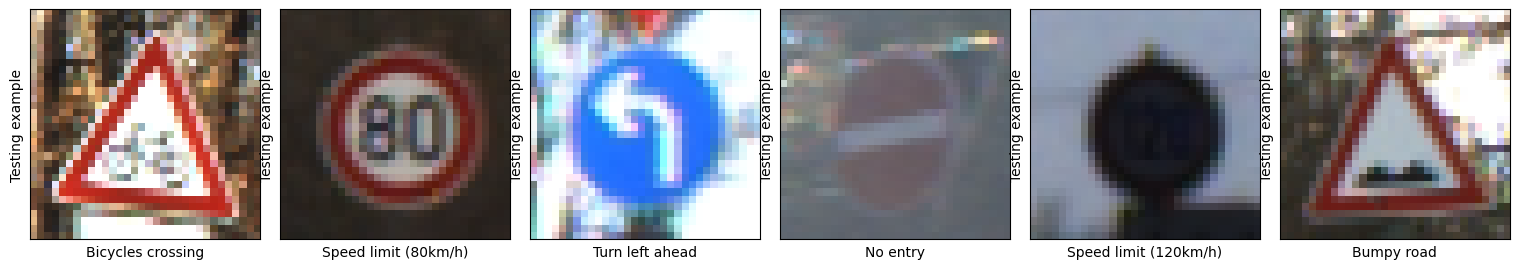

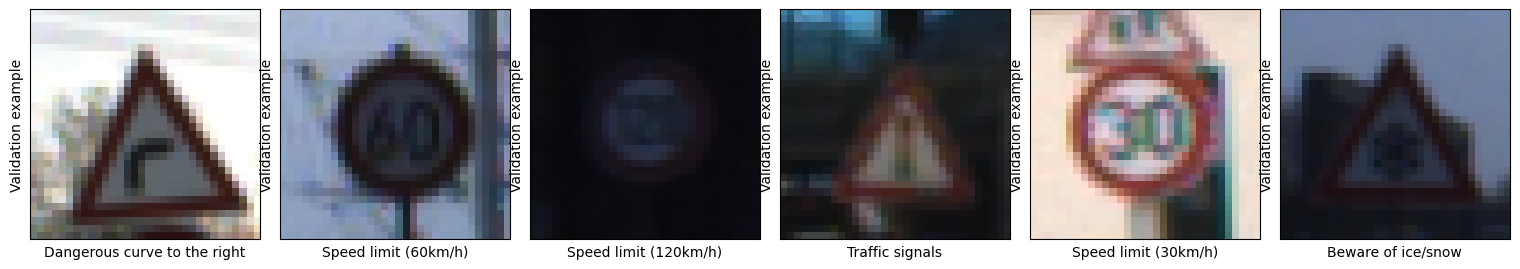

In [6]:
# Plotting sample examples
list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")
list_images(X_valid, y_valid, "Validation example")

In [7]:
def histogram_plot(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()

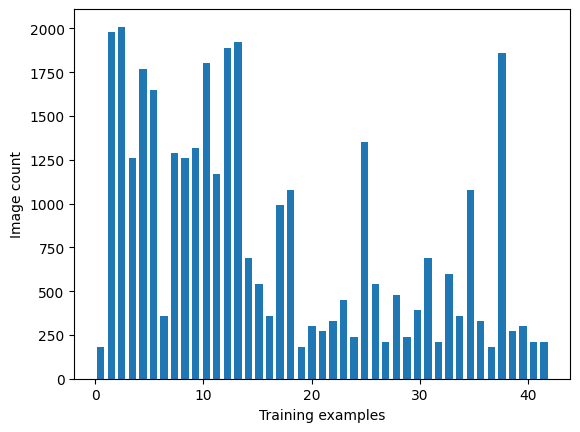

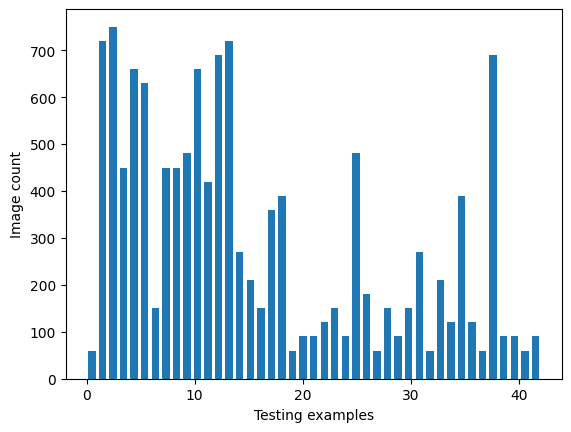

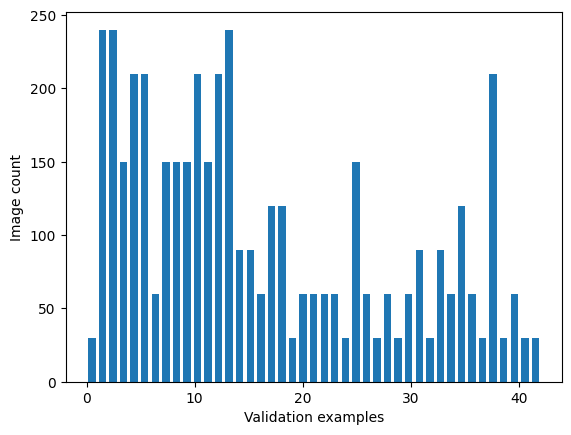

In [8]:
# Plotting histograms of the count of each sign
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_valid, "Validation examples")

In [9]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img

In [10]:
_classes, counts = np.unique(y_train, return_counts=True)

for _class, count in zip(_classes, counts):
    new_images = []
    new_classes = []
                
    if count < 1000:
        y_train_length = y_train.shape[0]
        index = 0
                    
        for i in range(0, 1000-count):
            while y_train[index] != _class:
                index = random.randint(0, y_train_length-1)
            new_images.append(transform_image(X_train[index],10,5,5,brightness=1))
            new_classes.append(_class)
        X_train = np.concatenate((X_train, np.array(new_images)))
        y_train = np.concatenate((y_train, np.array(new_classes)))

print("Number of training examples = "+ str(X_train.shape[0]))

Number of training examples = 51690


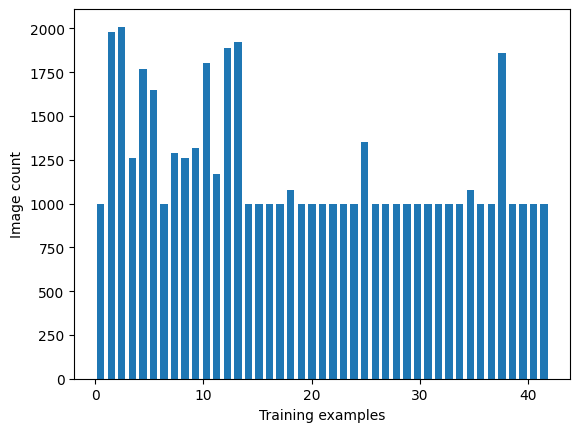

In [11]:
histogram_plot(y_train, "Training examples")

In [12]:
X_train, y_train = shuffle(X_train, y_train)

In [13]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

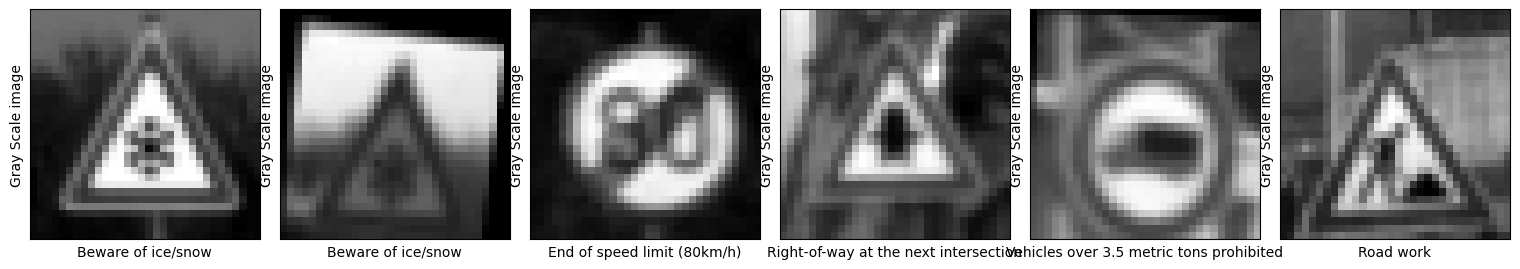

In [14]:
# Sample images after greyscaling
gray_images = list(map(gray_scale, X_train))
list_images(gray_images, y_train, "Gray Scale image", "gray")

In [15]:
def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, kernel)
    return img_local

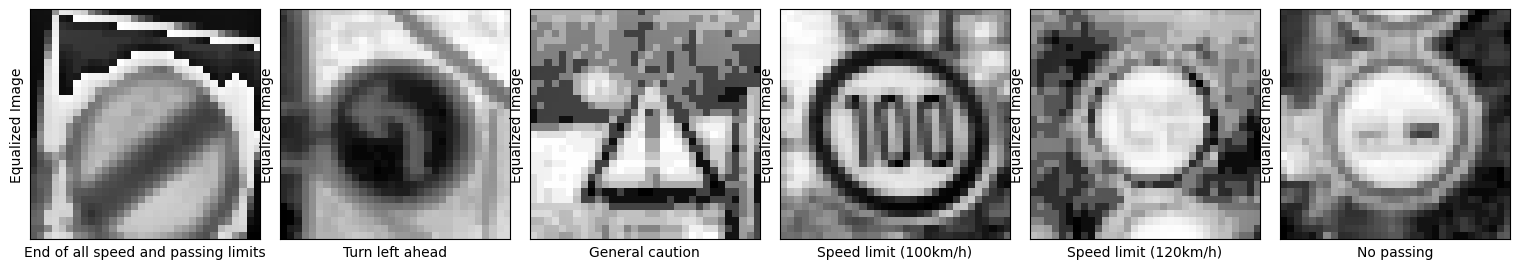

In [16]:
# Sample images after Local Histogram Equalization
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")

In [17]:
def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

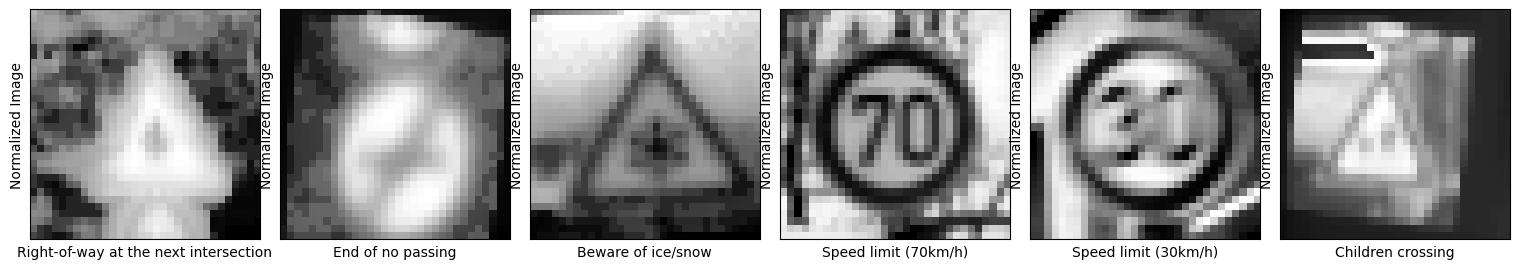

In [18]:
# Sample images after normalization
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

In [19]:
def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

In [20]:
class LaNet(tf.Module):

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        super(LaNet, self).__init__()
        self.mu = mu
        self.sigma = sigma
        self.learning_rate =learning_rate
        self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)

        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1)),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(n_out)
        ])
    
    def accuracy(self, logits, labels):
        predicted_classes = tf.argmax(logits, axis=1)
        correct_predictions = tf.equal(predicted_classes, tf.cast(labels, tf.int64))
        return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            logits = self.model(x)
            y_onehot = tf.one_hot(y, depth=self.n_out)  # One-hot encode labels
            loss_value = self.loss(logits, y_onehot)
        gradients = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss_value

    def fit(self, x_train, y_train, batch_size=64, epochs=10):
        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch_x, batch_y in zip(
                    tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)):
                batch_x = tf.cast(batch_x, dtype=tf.float32)
                batch_y = tf.cast(batch_y, dtype=tf.float32)

                loss_value = self.train_step(batch_x, batch_y)
                epoch_loss += loss_value

            avg_epoch_loss = epoch_loss / len(x_train) * batch_size
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    def evaluate(self, x_data, y_data, batch_size=64):
        accuracy_values = []
        dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).batch(batch_size)
        
        for batch_x, batch_y in dataset:
            batch_x = tf.cast(batch_x, dtype=tf.float32)
            batch_y = tf.cast(batch_y, dtype=tf.float32)
            
            logits = self.model(batch_x)
            batch_accuracy = self.accuracy(logits, batch_y)
            accuracy_values.append(batch_accuracy)

        avg_accuracy = tf.reduce_mean(accuracy_values)
        return avg_accuracy.numpy()

    def y_predict(self, x_data, batch_size=64):
        y_pred = []
        for batch_x in tf.data.Dataset.from_tensor_slices(x_data).batch(batch_size):
            batch_x = tf.cast(batch_x, dtype=tf.float32)

            logits = self.model(batch_x)
            batch_predictions = tf.argmax(logits, axis=1)
            y_pred.extend(batch_predictions.numpy())

        return np.array(y_pred)
    def loss(self, logits, labels):
        return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True))


In [21]:
class VGGnet(tf.Module):

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        super(VGGnet, self).__init__()
        self.mu = mu
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.n_out = n_out 
        self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)

        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(n_out)
        ])

    def loss(self, logits, labels):
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))

    def accuracy(self, logits, labels):
        y_onehot = tf.one_hot(labels, depth=self.n_out)  # One-hot encode labels
        correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(y_onehot, 1))
        return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            y_onehot = tf.one_hot(y, depth=self.n_out)  # One-hot encode labels
            loss_value = self.loss(logits, y_onehot)
        
        gradients = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss_value

    def fit(self, x_train, y_train, batch_size=64, epochs=10):
        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch_x, batch_y in zip(
                    tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)):
                batch_x = tf.cast(batch_x, dtype=tf.float32)
                batch_y = tf.cast(batch_y, dtype=tf.float32)

                loss_value = self.train_step(batch_x, batch_y)
                epoch_loss += loss_value

            avg_epoch_loss = epoch_loss / len(x_train) * batch_size
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    def evaluate(self, x_data, y_data, batch_size=64):
        accuracy_values = []
        dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).batch(batch_size)
        
        for batch_x, batch_y in dataset:
            batch_x = tf.cast(batch_x, dtype=tf.float32)
            batch_y = tf.cast(batch_y, dtype=tf.int32)  # Ensure batch_y has int32 data type
            
            logits = self.model(batch_x)
            batch_accuracy = self.accuracy(logits, batch_y)
            accuracy_values.append(batch_accuracy)

        avg_accuracy = tf.reduce_mean(accuracy_values)
        return avg_accuracy.numpy()


    def y_predict(self, x_data, batch_size=64):
        y_pred = []
        for batch_x in tf.data.Dataset.from_tensor_slices(x_data).batch(batch_size):
            batch_x = tf.cast(batch_x, dtype=tf.float32)

            logits = self.model(batch_x)
            batch_predictions = tf.argmax(logits, axis=1)
            y_pred.extend(batch_predictions.numpy())

        return np.array(y_pred)


In [22]:
# Define dropout probabilities as regular tensors
keep_prob = tf.constant(0.5, dtype=tf.float32)       # For fully-connected layers
keep_prob_conv = tf.constant(0.7, dtype=tf.float32)  # For convolutional layers

In [23]:
# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)

In [24]:
EPOCHS = 30
BATCH_SIZE = 64
DIR = 'Saved_Models'

In [25]:
import tensorflow as tf
from sklearn.utils import shuffle

# Create an instance of the LeNet class
LeNet_Model = LaNet(n_out=n_classes)
model_name = "LeNet"

# Create an optimizer
optimizer = tf.optimizers.Adam(learning_rate=LeNet_Model.learning_rate)

# Training loop
for epoch in range(EPOCHS):
    normalized_images, y_train = shuffle(normalized_images, y_train)
    num_batches = len(y_train) // BATCH_SIZE
    
    for batch_num in range(num_batches):
        start_idx = batch_num * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE
        batch_x, batch_y = normalized_images[start_idx:end_idx], y_train[start_idx:end_idx]
        
        with tf.GradientTape() as tape:
            logits = LeNet_Model.model(batch_x, training=True)
            loss_value = LeNet_Model.loss(logits, batch_y)
        
        gradients = tape.gradient(loss_value, LeNet_Model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, LeNet_Model.trainable_variables))
    
    validation_accuracy = LeNet_Model.evaluate(X_valid_preprocessed, y_valid)
    print("Epoch {} : Validation Accuracy = {:.3f}%".format(epoch + 1, (validation_accuracy * 100)))

# Save the model
LeNet_Model.model.save(os.path.join(DIR, model_name))
print("Model saved")


Epoch 1 : Validation Accuracy = 75.661%
Epoch 2 : Validation Accuracy = 83.940%
Epoch 3 : Validation Accuracy = 85.935%
Epoch 4 : Validation Accuracy = 88.356%
Epoch 5 : Validation Accuracy = 88.268%
Epoch 6 : Validation Accuracy = 89.911%
Epoch 7 : Validation Accuracy = 90.210%
Epoch 8 : Validation Accuracy = 90.029%
Epoch 9 : Validation Accuracy = 90.573%
Epoch 10 : Validation Accuracy = 91.685%
Epoch 11 : Validation Accuracy = 92.296%
Epoch 12 : Validation Accuracy = 92.047%
Epoch 13 : Validation Accuracy = 90.824%
Epoch 14 : Validation Accuracy = 91.119%
Epoch 15 : Validation Accuracy = 92.638%
Epoch 16 : Validation Accuracy = 92.792%
Epoch 17 : Validation Accuracy = 91.685%
Epoch 18 : Validation Accuracy = 92.611%
Epoch 19 : Validation Accuracy = 92.615%
Epoch 20 : Validation Accuracy = 92.185%
Epoch 21 : Validation Accuracy = 93.738%
Epoch 22 : Validation Accuracy = 91.866%
Epoch 23 : Validation Accuracy = 92.633%
Epoch 24 : Validation Accuracy = 93.315%
Epoch 25 : Validation Acc

INFO:tensorflow:Assets written to: Saved_Models\LeNet\assets


INFO:tensorflow:Assets written to: Saved_Models\LeNet\assets


Model saved


In [26]:
VGGNet_Model = VGGnet(n_out=n_classes)
model_name = "VGGNet"

# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)

# Initialize optimizer
optimizer = tf.optimizers.Adam(learning_rate=VGGNet_Model.learning_rate)

print("Training...")
print()
for i in range(EPOCHS):
    normalized_images, y_train = shuffle(normalized_images, y_train)
    num_batches = len(y_train) // BATCH_SIZE
    
    # Initialize variables to accumulate losses and accuracies
    total_loss = 0.0
    total_accuracy = 0.0
    
    for batch_num in range(num_batches):
        start_idx = batch_num * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE
        batch_x, batch_y = normalized_images[start_idx:end_idx], y_train[start_idx:end_idx]
        
        with tf.GradientTape() as tape:
            # Perform a training step and accumulate loss
            loss_value = VGGNet_Model.train_step(batch_x, batch_y)
            total_loss += loss_value
        
        gradients = tape.gradient(loss_value, VGGNet_Model.trainable_variables)
        gradients = [grad if grad is not None else tf.zeros_like(var) for grad, var in zip(gradients, VGGNet_Model.trainable_variables)]
        
        optimizer.apply_gradients(zip(gradients, VGGNet_Model.trainable_variables))
        
        # Compute batch accuracy
        logits = VGGNet_Model.model(batch_x)
        batch_accuracy = VGGNet_Model.accuracy(logits, batch_y)
        total_accuracy += batch_accuracy
    
    # Calculate average loss and accuracy for the epoch
    avg_epoch_loss = total_loss / num_batches
    avg_epoch_accuracy = total_accuracy / num_batches
    
    # Evaluate the model on the validation set
    validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
    
    print("EPOCH {} : Loss = {:.4f}, Training Accuracy = {:.3f}%, Validation Accuracy = {:.3f}%".format(
        i + 1, avg_epoch_loss, avg_epoch_accuracy * 100, validation_accuracy * 100))
    
# Save the model using TensorFlow 2.x methods
VGGNet_Model.model.save(os.path.join(DIR, model_name))
print("Model saved")


Training...

EPOCH 1 : Loss = 3.7327, Training Accuracy = 3.929%, Validation Accuracy = 5.435%
EPOCH 2 : Loss = 3.7296, Training Accuracy = 3.828%, Validation Accuracy = 5.435%
EPOCH 3 : Loss = 3.7287, Training Accuracy = 3.824%, Validation Accuracy = 5.435%
EPOCH 4 : Loss = 3.7285, Training Accuracy = 3.748%, Validation Accuracy = 5.435%
EPOCH 5 : Loss = 3.7281, Training Accuracy = 3.776%, Validation Accuracy = 5.435%
EPOCH 6 : Loss = 3.7279, Training Accuracy = 3.863%, Validation Accuracy = 5.435%
EPOCH 7 : Loss = 3.7278, Training Accuracy = 3.886%, Validation Accuracy = 5.435%
EPOCH 8 : Loss = 3.7275, Training Accuracy = 3.853%, Validation Accuracy = 5.435%
EPOCH 9 : Loss = 3.7275, Training Accuracy = 3.874%, Validation Accuracy = 5.435%
EPOCH 10 : Loss = 3.7274, Training Accuracy = 3.909%, Validation Accuracy = 5.435%
EPOCH 11 : Loss = 3.7274, Training Accuracy = 3.750%, Validation Accuracy = 5.435%
EPOCH 12 : Loss = 3.7274, Training Accuracy = 3.868%, Validation Accuracy = 5.435%


INFO:tensorflow:Assets written to: Saved_Models\VGGNet\assets


INFO:tensorflow:Assets written to: Saved_Models\VGGNet\assets


Model saved


In [27]:
X_test_preprocessed = preprocess(X_test)

In [28]:
# Load the saved model
loaded_model = tf.keras.models.load_model(os.path.join(DIR, "VGGNet"))

# Make predictions on the test set
y_pred = loaded_model.predict(X_test_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate test accuracy
test_accuracy = np.sum(y_test == y_pred_classes) / len(y_test)
print("Test Accuracy = {:.1f}%".format(test_accuracy * 100))

395/395 [==============================] - 1s 2ms/step
Test Accuracy = 5.9%


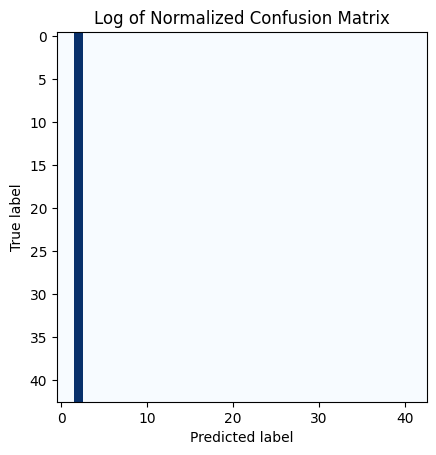

In [29]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(1e-4 + cm)

# Plot the log-scaled normalized confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of Normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()